# CLASSIFICATION OF LAB SAMPLES

This notebook analyzes the accuracy of the SVM classifier on the training data and on lab samples.
The training data are:
* all genes (not just regulators);
* averaged;
* do not include T1 (since only one observtion)

# TO DO
1. **Check calculation of pooled, whether average log**
1. Structure codes for the analyses conducted. This structure should be reflected in ``DATA_DCT``.
   1. Selection of genes: myco, myco +, all genes
   1. How counts are processed
      1. Reference - T0/biostat, T0/data source, pooled/data source
1. Evaluation of classifiers
   1. Performance on biostat data
   1. Performance on other samples
      1. Time consistency
      1. Replication consistency
      1. Consistency with expectation
1. Analyses for Eliza:
   1. Accuracy with all 11 and the accuracy as you add in more genes (same as what you just sent but with all 11).
   1. Could you test with just the 10 mycobactin genes (Rv2377c-Rv2386c)?
   1. Could you test with just bacterioferritin (Rv3841)? Just Rv2384?
   1. Is there one gene that gives good accuracy
1. compare accuracy with ranom selection of genes
1. Classifier coefficient profile.
   1. Eliza genes - 1-10
   1. Auto selected genes: 5, 10, 20

# Preliminaries

## Imports

In [1]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData, REF_TYPE_BIOREACTOR, REF_TYPE_SELF, REF_TYPE_POOLED
from common.data_provider import DataProvider
from common import trinary_data
from common_python.plots import util_plots
from common_python.classifier import classifier_ensemble
from common_python.classifier import classifier_collection
from common_python.util.persister import Persister
from common_python.util import dataframe
from common import transform_data

import collections
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score
import seaborn as sns

%matplotlib inline

## Constants

In [2]:
# Run control
FULL_RUN = True
REINITIALIZE_PERSISTER = True

In [3]:
# Files
DIR = os.path.abspath(".")
PERSISTER_PATH = os.path.join(DIR, "classification_of_lab_samples.pcl")
PERSISTER = Persister(PERSISTER_PATH)

In [4]:
# Data preparation constants
T0 = "T0"
POOLED = "pooled"

In [5]:
# Test samples. This is a dictionary (key is the control) of dictionaries (key is the data sample)
def updateSampleDct(sample_dct):
    for name, sample_data in sample_dct.items():
        data_dct = {n: sample_data.__getattribute__(n) for n in trinary_data.SAMPLES}
        sample_dct[name] = data_dct

In [6]:
# Generic provider to supply non-readcount data and access to DataProvider methods
PROVIDER = DataProvider()
PROVIDER.do()
trinary = TrinaryData()
ALL_GENES = list(trinary.df_X.columns)

In [27]:
# Gene groupings
MYCOBACTIN_GENES = [
"Rv2377c",
"Rv2378c",
"Rv2379c",
"Rv2380c",
"Rv2381c",
"Rv2382c",
"Rv2383c",
"Rv2384",
"Rv2385",
"Rv2386c",
]
BACTERIOFERRITIN_GENES = [
"Rv2341", "Rv3841", 
]
MYCOBACTIN_BACTERIOFERRIN_GENES = list(MYCOBACTIN_GENES)
MYCOBACTIN_BACTERIOFERRIN_GENES.extend(BACTERIOFERRITIN_GENES)
GENE_DCT = {"mycobactin": MYCOBACTIN_GENES,
            "bacterioferritin": BACTERIOFERRITIN_GENES,
            "mycobactin_bacterioferritin": MYCOBACTIN_BACTERIOFERRIN_GENES,
            "all": ALL_GENES,
           }

In [8]:
STAGE_NAMES = list(cn.STATE_NAMES)
STAGE_NAMES.remove("Normoxia")
STAGE_NAMES = np.array(STAGE_NAMES)

In [29]:
# Remove the Persister if data has changed
if REINITIALIZE_PERSISTER:
    PERSISTER.remove()
#
PERSISTED_VARIABLES = ["DATA_DCT", "SAMPLE_DCT", "CLASSIFIER_BASE", "CLASSIFIER_DCT", "DF_X_DCT", "SER_Y_DCT"]
persisted_str = ", ".join(PERSISTED_VARIABLES)
if PERSISTER.isExist():
    stmt = "%s = PERSISTER.get()" % persisted_str
    exec(stmt)
else:
    # Bioreactor data calculated with two different references
    DATA_DCT = {
        T0: TrinaryData(is_regulator=False, is_dropT1=True, is_averaged=True),
        POOLED: TrinaryData(is_regulator=False, is_dropT1=True,
                            is_averaged=True, calcRef=PROVIDER.calcRefPooled)
    }
    SER_Y_DCT = {k: t.ser_y for k,t in DATA_DCT.items()}
    # Feature vectors are specific to the gene subsets
    DF_X_DCT = {k: t.df_X.copy() for k,t in DATA_DCT.items()}
    DF_X_DCT = {k: df[MYCOBACTIN_GENES] for k, df in DF_X_DCT.items()}
    # Sample data
    SAMPLE_DCT = {r: trinary_data.getSampleData(ref_type=r, is_regulator=False) for r in [REF_TYPE_BIOREACTOR, REF_TYPE_SELF, REF_TYPE_POOLED]}
    # Classifiers
    CLASSIFIER_BASE = classifier_ensemble.ClassifierEnsemble(
          classifier_ensemble.ClassifierDescriptorSVM(), filter_high_rank=15, size=100)
    CLASSIFIER_DCT = {}
    for trinary_key, trinary in DATA_DCT.items():
        for gene_key, gene_list in GENE_DCT.items():
            classifier = copy.deepcopy(CLASSIFIER_BASE)
            # Not all genes may be present in TrinaryData since they may be correlated or unvarying.
            df_X = dataframe.subset(trinary.df_X, gene_list, axis=1)
            classifier.fit(df_X, trinary.ser_y, class_names=STAGE_NAMES)
            CLASSIFIER_DCT[(trinary_key, gene_key)] = classifier
    updateSampleDct(SAMPLE_DCT)
    #
    stmt = "PERSISTER.set((%s))" % persisted_str
    exec(stmt)


***
**No self reference defined for GSE167232. Using bioreactor data.




In [30]:
# TESTS For CLASSIFIER_DCT, DATA_DCT
for classifier_key, classifier_clf in CLASSIFIER_DCT.items():
    # Got expected genes in the feature vector?
    for gene_key, gene_list in GENE_DCT.items():
        if gene_key == classifier_key[1]:
            assert(len(gene_list) >= len(classifier_clf._df_X.columns))
    # Got expected data
    for data_key in DATA_DCT.keys():
        if data_key == classifier_key[0]:
            # Find common genes
            columns = GENE_DCT[classifier_key[1]]
            test_df = dataframe.subset(DATA_DCT[data_key].df_X, columns)
            newColumns = list(test_df.columns)
            newColumns.sort()
            test_df = test_df[newColumns]
            df_X = classifier_clf._df_X.copy()
            df_X = df_X[newColumns]
            assert(test_df.equals(df_X))
    

In [31]:
# Construct derivative structures    
DF_X = DF_X_DCT[T0]
SER_Y = SER_Y_DCT[T0]
SAMPLE_DATA_DCT = SAMPLE_DCT[REF_TYPE_BIOREACTOR]
CLASSIFIER = CLASSIFIER_DCT[('T0', 'mycobactin')]
TRINARY = DATA_DCT['T0']
GENES = CLASSIFIER.features

## Helper Functions

In [12]:
def evaluateClassifierOnInstances(clf, **kwargs):
    clf.evaluateClassifierOnInstances(**kwargs)

In [13]:
def plotSampleData(data_dct, genes=GENES, is_plot=True):
    """
    Plots trinary values of data for the specified genes.
    
    Parameters
    ----------
    data_dct: dict
        key: data sample name
        value: feature vector
    genes: list-str
    """
    for name, df_X in data_dct.items():
        TRINARY.plotExpressionLevels(genes, df_X=df_X, title=name, is_plot=is_plot)
            
# Tests
plotSampleData(SAMPLE_DCT[REF_TYPE_BIOREACTOR], is_plot=False)
print("OK!")

OK!


In [14]:
def reportSamplePredictions(data_dct):
    for name, df_X in data_dct.items():
        print("\n%s" % name)
        df_pred = CLASSIFIER.predict(df_X)
        new_columns = [STAGE_NAMES[c] for c in df_pred.columns]
        df_pred.columns = new_columns
        print(df_pred)

OK!


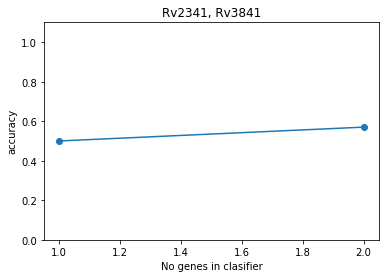

In [47]:
def plotAccuracy(genes, title="", selected_stages=None, size=100, is_plot=True, ax=None):
    """
    Plots the accuracy curve for a collection of genes
    
    Parameters
    ----------
    genes: list-str
    title: str
    selected_stages: list-str
        Create a binary classifier for just these tages
    size: int
    is_plot: bol
    """
    if ax is None:
        _, ax = plt.subplots(1)
    accuracy_dct = {}
    #data = mkDataSubset(genes, selected_stages=selected_stages)
    data = DATA_DCT[T0].subsetToStates(selected_stages, genes=genes)
    ranks = range(1, len(genes) + 1)
    for rank in ranks:
        accuracy_dct[rank] = CLASSIFIER.crossValidate(
            data, num_iter=10, num_holdout=1, filter_high_rank=rank, size=size)
    ax.plot(list(accuracy_dct.keys()), list(accuracy_dct.values()), marker="o")
    ax.set_ylim([0, 1.1])
    _ = ax.set_xlabel("No genes in clasifier")
    _ = ax.set_ylabel("accuracy")
    ax.set_title(title)
    if not is_plot:
        plt.close()
    return accuracy_dct
    
# Tests
genes = GENE_DCT["bacterioferritin"]
accuracy_dct = plotAccuracy(GENE_DCT["bacterioferritin"], title=", ".join(genes), selected_stages="StageII", size=5, is_plot=True)
assert(np.isclose(list(accuracy_dct.values())[0], 0.5))
print("OK!")

## Data

### BioReactor

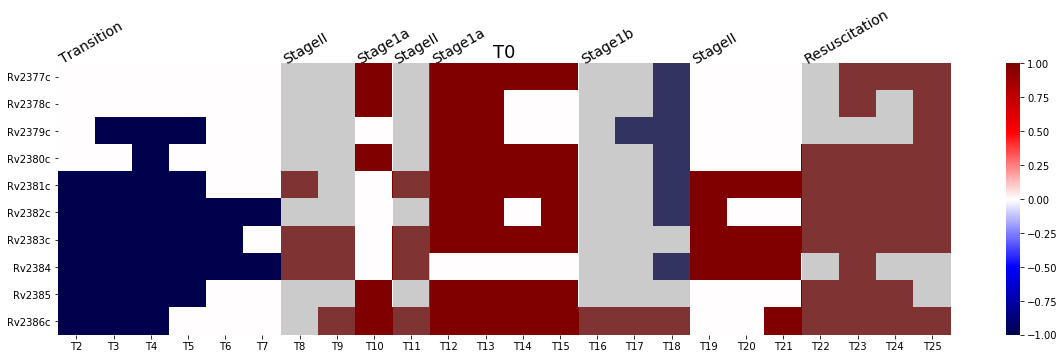

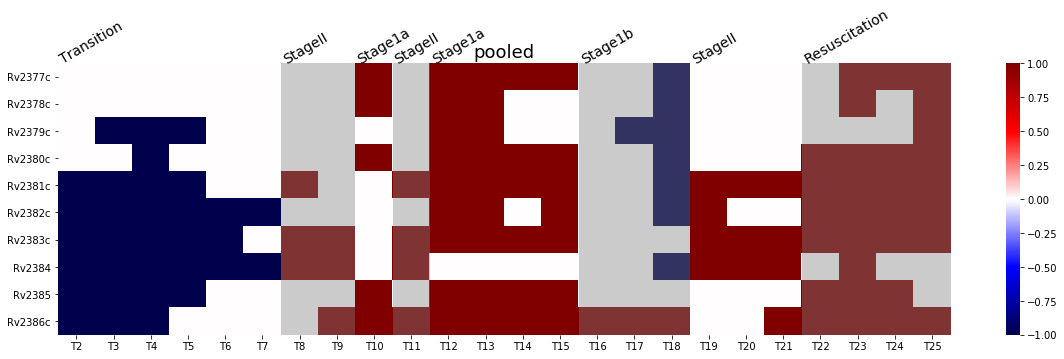

In [15]:
for ref, df in DF_X_DCT.items():
    TRINARY.plotExpressionLevels(df.columns, title="%s" % ref)

In [16]:
if FULL_RUN:
    for key, clf in CLASSIFIER_DCT.items():
        suptitle = "%s: Acc=%1.2f" % ("_".join(key), np.mean(CLASSIFIER_DCT[key].scores))
        evaluateClassifierOnInstances(CLASSIFIER_DCT[key], ser_y=DATA_DCT[key[0]].ser_y, nrow=4, ncol=6, suptitle=suptitle)

### Lab Samples

**Observations**
1. Prefer control values that avoid having a constant value of the trinary value over the samples (since such a situation is unhelpful for distinguishing classes).
1. On training data (Bioreactor)
   1. Many genes have the same within class values
   1. Few genes have the same between class values

**TO DO**: Plot data in pairs, 1 column, 2 rows; this allows comparisons of the expressions for T0 vs. pooled.

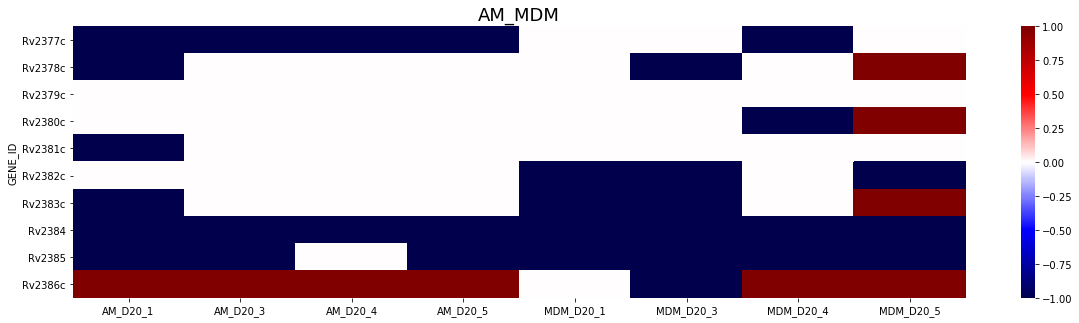

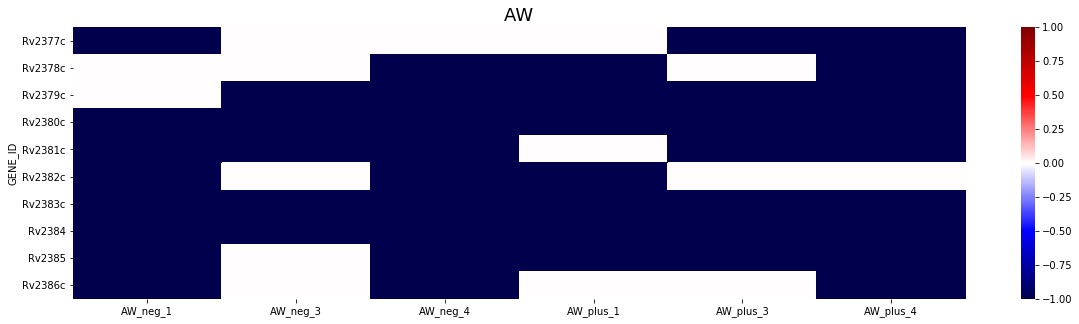

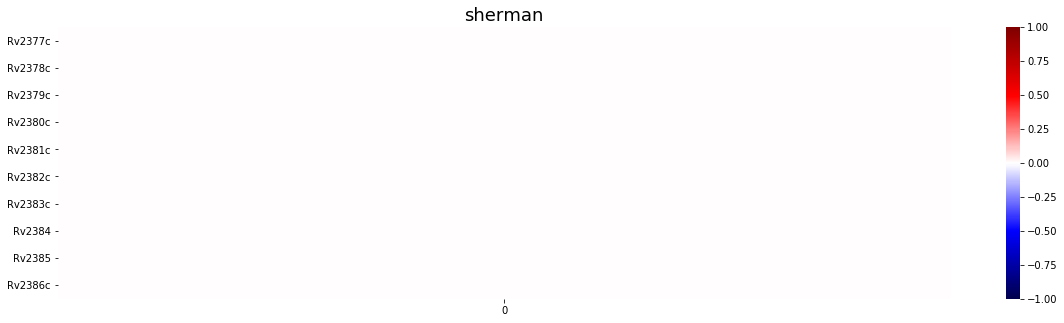

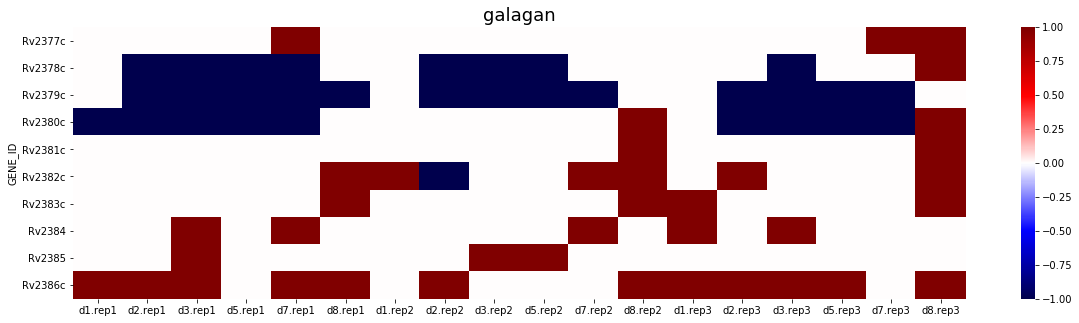

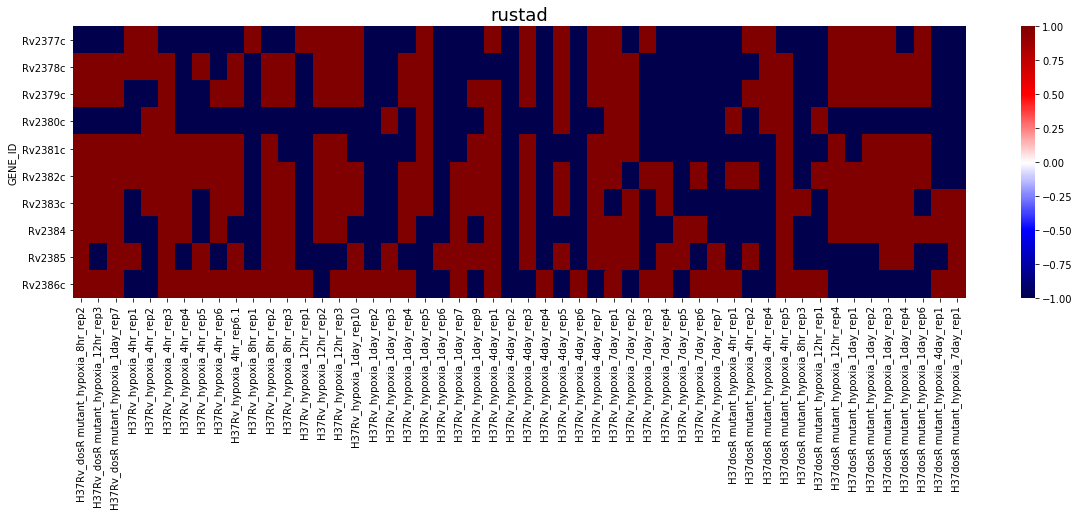

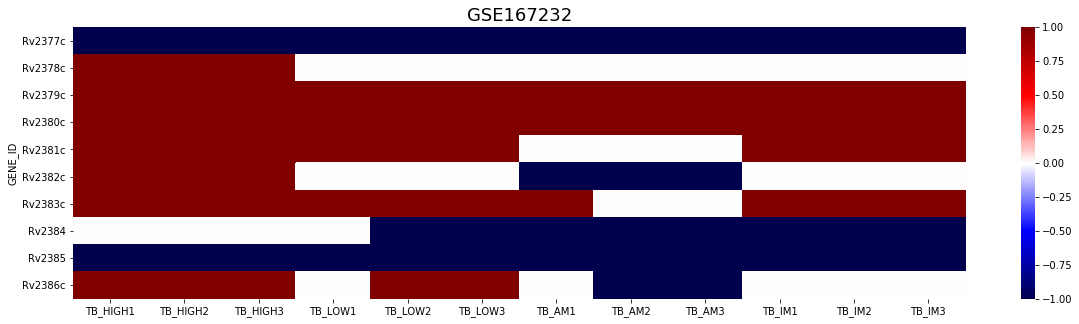

In [17]:
# With Bioreactor reference data
plotSampleData(SAMPLE_DCT[REF_TYPE_BIOREACTOR])

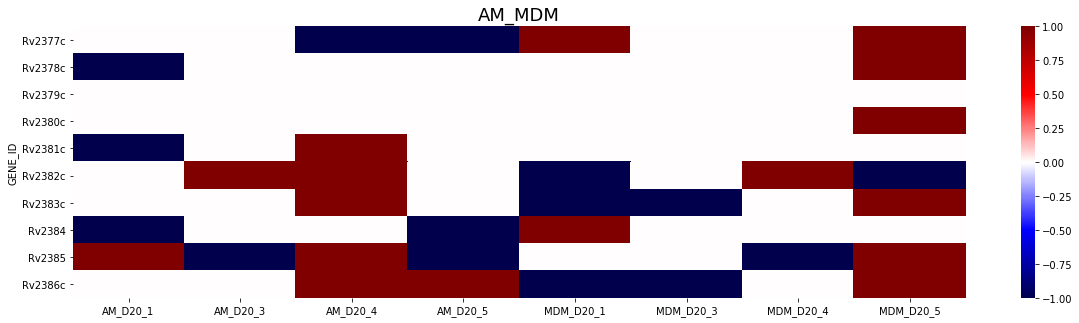

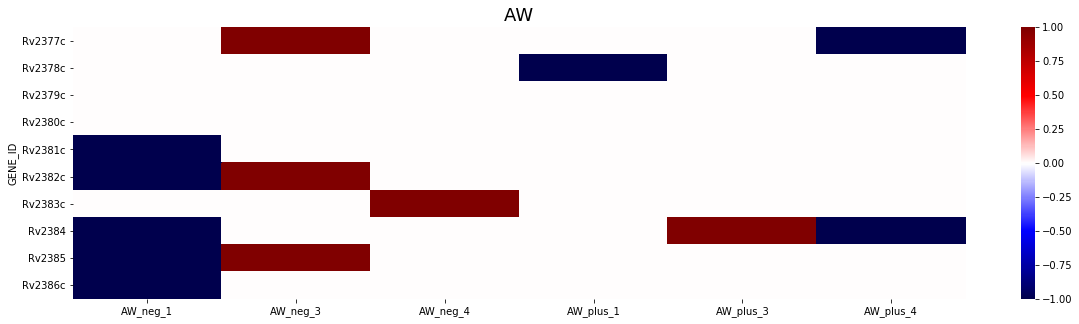

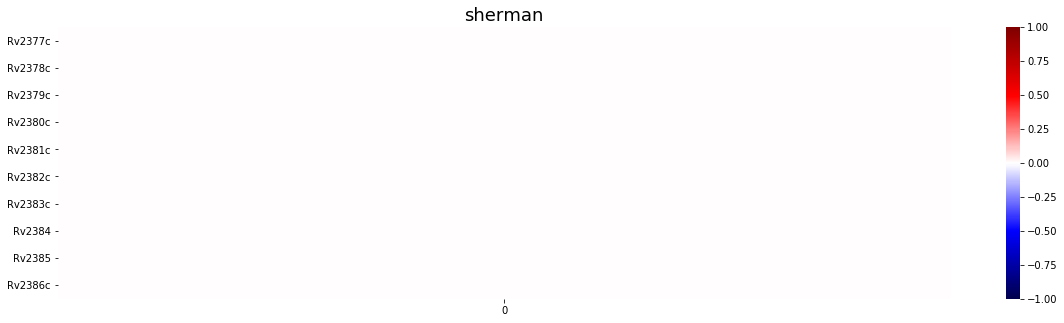

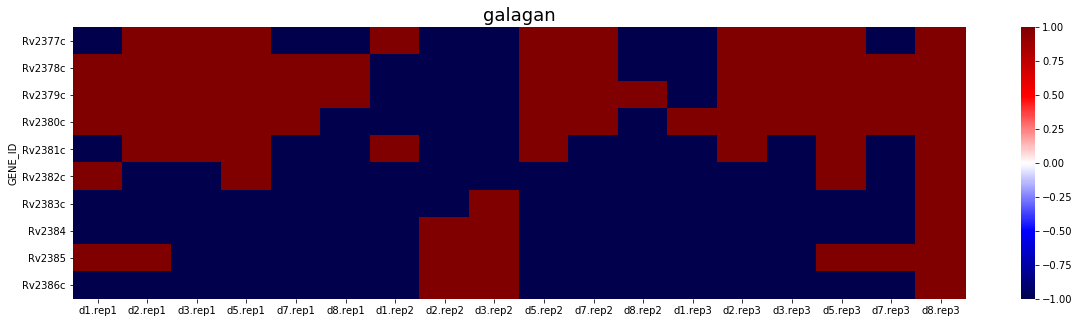

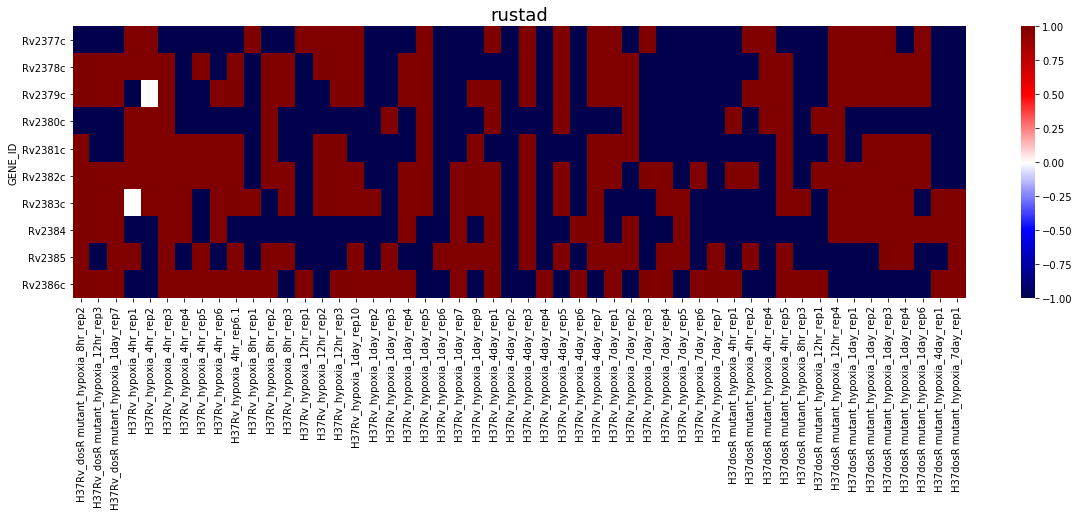

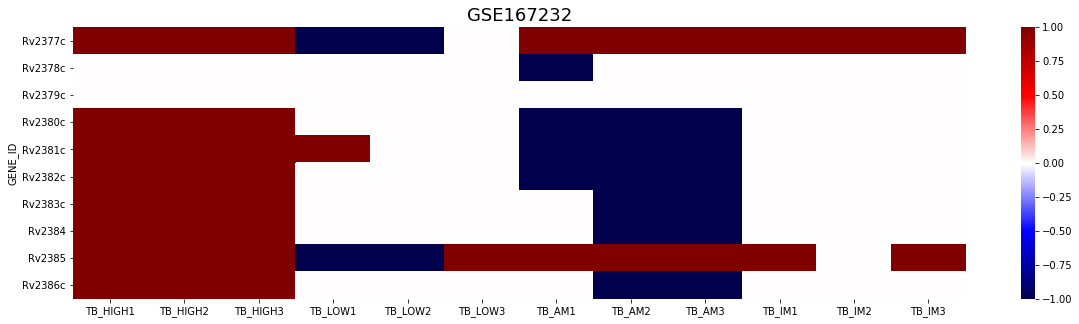

In [18]:
# With pooled reference data
plotSampleData(SAMPLE_DCT[REF_TYPE_POOLED])

# Classification Validations on Training Samples
Classify T2-T25 and see if result is same as original class. Use 5-fold cross validation, where there is a holdout for each class and the selection is random.


In [19]:
# Plot accuracy for the number of genes
if FULL_RUN:
    legends = []
    _, ax = plt.subplots(1, figsize=(18, 10))
    for key, clf in CLASSIFIER_DCT.items():
        legends.append("--".join(key))
        accuracy_dct = {}
        ranks = [2*r for r in range(1,11)]
        ranks.insert(0, 1)
        trinary = copy.deepcopy(DATA_DCT[key[0]])
        trinary.df_X = dataframe.subset(trinary.df_X, GENE_DCT[key[1]])
        for rank in ranks:
            accuracy_dct[rank] = clf.crossValidate(
                trinary, num_iter=10, num_holdout=1, filter_high_rank=rank, size=100)
        ax.plot(list(accuracy_dct.keys()), list(accuracy_dct.values()))
        ax.set_ylim([0, 1.1])
        _ = ax.set_xlabel("No genes in clasifier")
        _ = ax.set_ylabel("accuracy")
        ax.legend(legends)

**TODO**: Verify values plotted for coefficients.

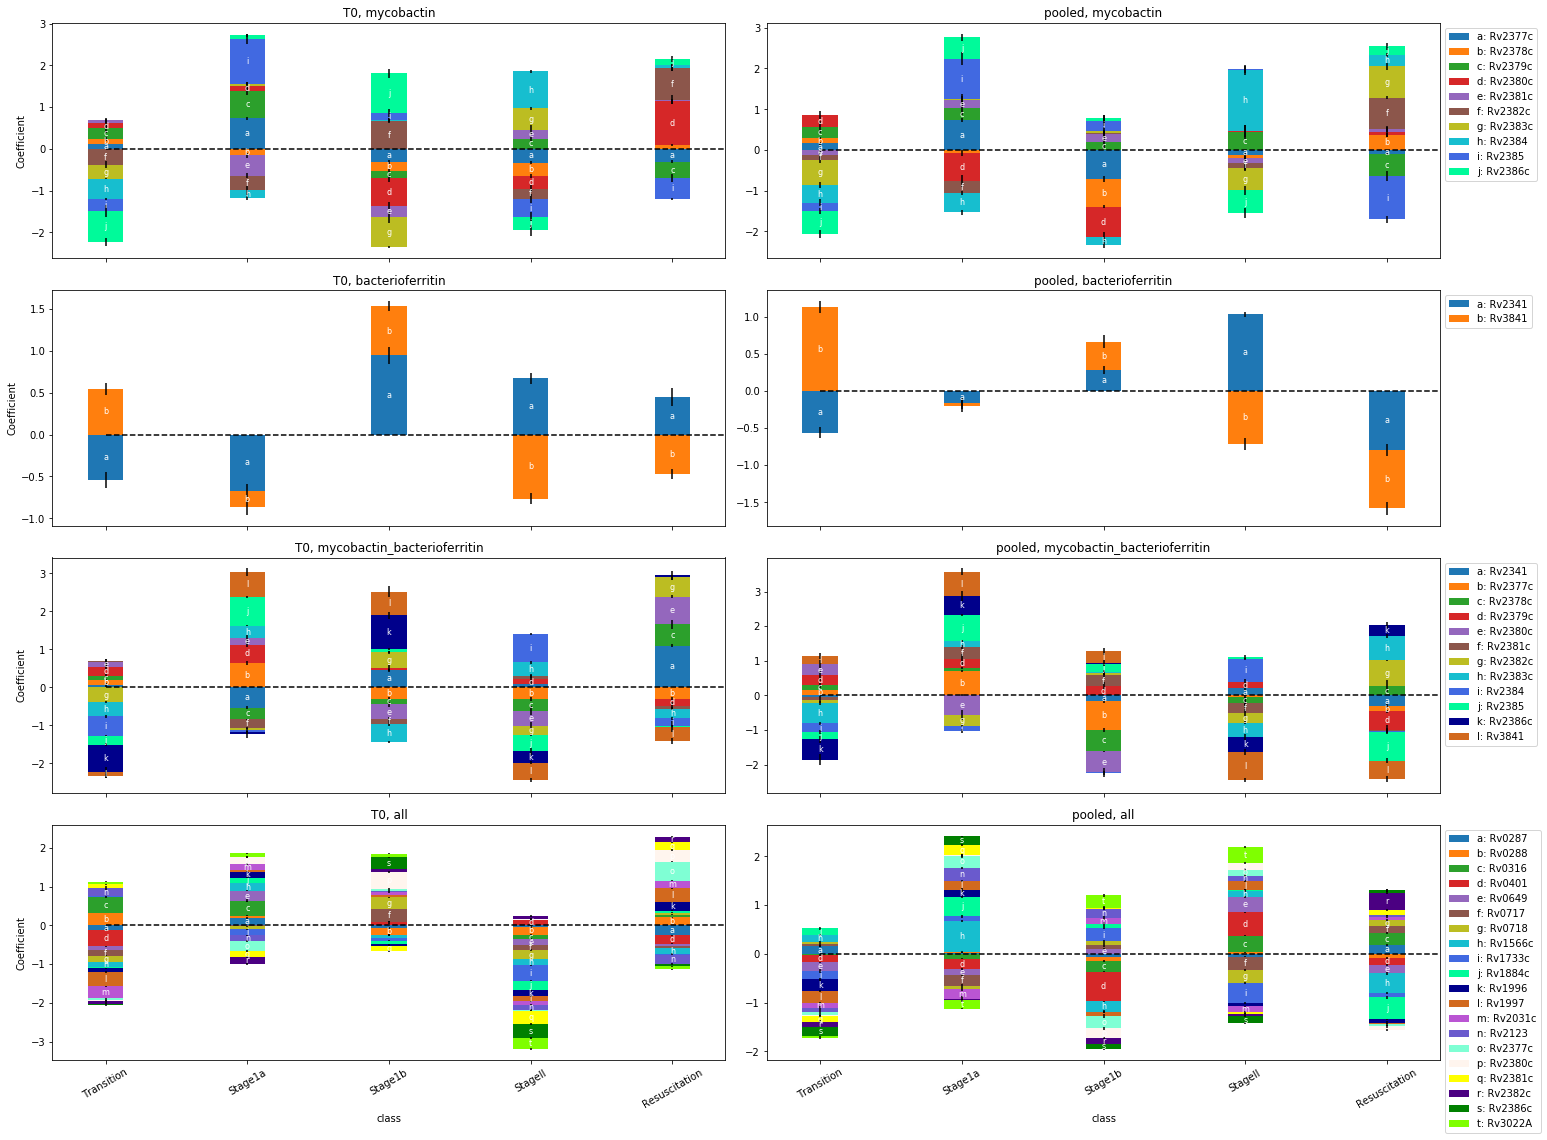

In [44]:
# Plot the classifier coefficients for each gene
nrow = 4
ncol = 2
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 15))
fig.tight_layout()
keys = []
irow = 0
for genes in ["mycobactin", "bacterioferritin", "mycobactin_bacterioferritin", "all"]:
    icol = 0
    for ref in ["T0", "pooled"]:
        key = (ref, genes)
        clf = CLASSIFIER_DCT[key]
        title = ", ".join(key)
        if icol == 1:
            is_legend = True
        else:
            is_legend = False
        ax = axes[irow, icol]
        clf.plotSVMCoefficients(title=title, ax=ax, class_names=STAGE_NAMES, is_plot=False, is_legend=is_legend)
        if irow < nrow - 1:
            ax.set_xticklabels([])
            ax.set_xlabel("")
        if icol > 0:
            ax.set_ylabel("")
        icol += 1
    irow += 1
plt.show()

**TO DO**: Note difference in roles of genes for each state based on pooled vs. TO.

The above chart displays the values of the SVM coefficients for each of the genes for the classifier used to identify each state. The vertical lines are error bars ($\pm$ 1 standard deviation) for the value of the coefficient over 100 classifiers constructed using 1 holdout per state.

The coefficients are used to identify the stage that best matches a gene expression vector. Given
an expression vector $\mathbf{x} = (x_1, \cdots, x_N)$, where $x_n \in [-1, 1 ]$ is the expression level of gene $x_n$ and
$c_{m,n}$ is the coefficient for the classifier for stage $m$ and gene $n$:
1. $d_m = \sum_n c_{m,n} x_n$
1. Choose stage $m^{\star}$ such that $m^{\star} = arg max_m \{ d_m \}$

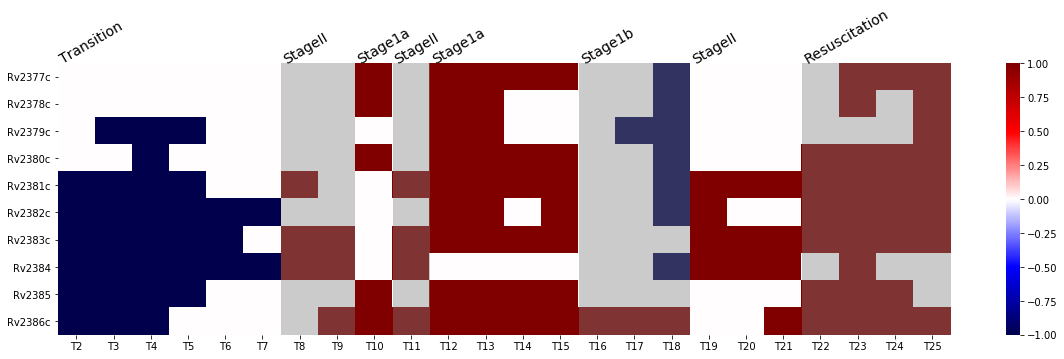

In [21]:
# Deeper look at training data
DATA_DCT[T0].plotExpressionLevels(CLASSIFIER.features, title="")

Several observations are of interest:
1. The coefficients for Transition are mostly negative, which means that this stage is about *under-expression*.
In particular, this stage is characterized by an under-expression of the genes Rv2383c, Rv2382c, Rv2386c, and Rv2385.
1. We see that Stage1a is characterized by large positive values of the coefficients for Rv2385, Rv3841, and Rv2384.
Although this makes sense for Rv2385, it is counter intuitive for
Rv2384 and Rv3841.
The rationale here is more complicated.
Rv2384 is not differentially expressed in Stage 1a; however, it is under-expressed in Transition.
So, a positive coefficient for Rv2384 for Stage 1a allows for differentiation from Transition.
A similar tactic seems to be in play for Rv3841 to distinguish Stage1a from Stage II and Resuscitation.
However, this is complicated by the fact that Transition over-expresses Rv3841.
The classifier compensates for this by having a large coefficient for Rv2384.

1. The other stages are characterized by a mixture of over- and under-expression.

# Accuracy of Gene Groups

In [ ]:
if False:
    gene_dct = {g: [g] for g in GENE_DCT["mycobactin"]}
    gene_dct.update(GENE_DCT)
    for name, genes in gene_dct.items():
        _, ax = plt.subplots(1)
        _ = accuracy_dct = plotAccuracy(genes, title=", ".join(genes), selected_stages=["StageII"], ax=ax, size=100)

In [ ]:
if False:
    gene_dct = {g: [g] for g in GENE_DCT["mycobactin"]}
    gene_dct.update(GENE_DCT)
    for name, genes in gene_dct.items():
        _, ax = plt.subplots(1)
        _ = accuracy_dct = plotAccuracy(genes, title=", ".join(genes), ax=ax, size=100)

In [ ]:
# Details for the 10 genes
if False:
    df_X = DF_X[GENE_DCT["mycobactin"]]
    num_genes = range(1, len(df_X.columns) + 1)
    num_genes = [10]
    for num_gene in num_genes:
        clf = classifier_ensemble.ClassifierEnsemble(
                classifier_ensemble.ClassifierDescriptorSVM(), filter_high_rank=num_gene, size=100)
        clf.fit(df_X, SER_Y)
        evaluateClassifierOnInstances(clf, df_X=df_X, ser_y=SER_Y, class_names=STAGE_NAMES, nrow=4, ncol=6, is_plot=True)

## Evaluation for good performing genes

# Classification of Samples

In [ ]:
CLASSIFIER.features

In [ ]:
CLASSIFIER.predict(SAMPLE_DATA_DCT["AM_MDM"])

In [ ]:
reportSamplePredictions(SAMPLE_DCT[REF_TYPE_BIOREACTOR])

In [ ]:
reportSamplePredictions(SAMPLE_DCT[REF_TYPE_POOLED])

# Detailed Analyses

## GSE167232

In [ ]:
TRINARY.plotExpressionLevels(CLASSIFIER.features, df_X=SAMPLE_DATA_DCT["GSE167232"], title="GSE167232")

In [ ]:
TRINARY.plotExpressionLevels(CLASSIFIER.features, df_X=SAMPLE_DCT[REF_TYPE_POOLED]["GSE167232"], title="GSE167232")

In [ ]:
#CLASSIFIER.plotFeatureContributions(df_X.loc["TB_AM1",:], class_names=STAGE_NAMES)
df_predict = CLASSIFIER.predict(SAMPLE_DATA_DCT["GSE167232"])
indexArr = np.reshape(list(df_predict.index), (4,3))
num_row = 4
num_col =3
_, axes = plt.subplots(num_row, num_col, figsize=(20, 12))
for irow in range(4):
    for icol in range(3):
        if icol == 0:
            is_ylabel = True
        else:
            is_ylabel = False
        if icol == num_col - 1:
            is_legend = True
        else:
            is_legend = False
        if irow == num_row - 1:
            is_xlabel = True
        else:
            is_xlabel = False
        instance = indexArr[irow, icol]
        ser_X = SAMPLE_DATA_DCT["GSE167232"].loc[instance, :]
        CLASSIFIER.plotFeatureContributions(ser_X, class_names=STAGE_NAMES, title=instance, ax=axes[irow,icol], is_plot=False,
                                           is_xlabel=is_xlabel, is_ylabel=is_ylabel, is_legend=is_legend)
plt.show()

## Rustad

In [ ]:
for ref_type in [REF_TYPE_BIOREACTOR, REF_TYPE_POOLED]:
    _, ax = plt.subplots(1)
    df_X = SAMPLE_DCT[ref_type]["rustad"]
    # Select hypoxia samples
    sel =  ["H37Rv_hypoxia" in i and (not "10" in i) for i in df_X.index]
    df_X = df_X[sel]
    # Select just replication 1-3
    sel =  [any([r in i for r in ["rep1", "rep2", "rep3"]])  for i in df_X.index]
    df_X = df_X[sel]
    #
    replFunc = lambda i: i[-4:]
    timeFunc = lambda i: i[-9:-6].replace("_", "")
    #time_strs = ["4hr", "12hr", "1day", "4day", "7day"]
    title = "rustad: " + ref_type
    CLASSIFIER.plotReplicationsOverTime(df_X, replFunc, timeFunc, title=title, ax=ax)

## AM, MDM

In [ ]:
SAMPLE_DATA_DCT["AM_MDM"]

## Galagan

In [ ]:
for ref_type in [REF_TYPE_BIOREACTOR, REF_TYPE_POOLED]:
    df_X = SAMPLE_DCT[ref_type]["galagan"]
    prediction_df = CLASSIFIER.predict(df_X)
    replFunc = lambda i: i[-4:]
    timeFunc = lambda i: i[0:2]
    title = "galagan: " + ref_type
    _, ax = plt.subplots(1)
    CLASSIFIER.plotReplicationsOverTime(df_X, replFunc, timeFunc, title=title, ax=ax)

# Summary Comments

1. Choice of control
   1. Criteria for choice
1. Evaluating the quality of classification for test samples
   1. Consistency between replications
   1. Consistency in stage progression of replication
1. Detailed summaries for data sets